# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

In this project, I will use the tools I learned about in the lesson to identify lane lines on the road.  I will develop a pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). 


## Import Packages

In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os

## Helper Functions

In [4]:
def grayscale(img):
    """ PREPARED FUNCTION
    Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def canny(img, low_threshold, high_threshold):
    """ PREPARED FUNCTION
    Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """ PREPARED FUNCTION
    Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """ PREPARED FUNCTION
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """ PREPARED FUNCTION
    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    """
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def draw_weighted_line(img, line, color=[255, 0, 0], thickness=10):
    """
    Draw weighted line on image
    :param img:
    :param line: in format as 4 points x0 = line[0], y0 = line[1], x1 = line[2], y1 = line[3]
    :param color:
    :param thickness:
    :return:
    """
    img_shape = img.shape
    line_img = np.zeros((img_shape[0], img_shape[1], 3), dtype=np.uint8)
    cv2.line(line_img, (line[0], line[1]), (line[2], line[3]), color, thickness)
    img_weighted = weighted_img(line_img, img)

    return img_weighted


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """ PREPARED FUNCTION
    `img` should be the output of a Canny transform.

    Returns lines found by hough transform
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    return lines


def hough_lines_visualize(lines, shape, color=[255, 0, 0], thickness=2):
    """
    Function to visualize hough_lines() results on the picture
    :param lines: lines obtained by hough_lines function
    :param shape: shape of the source picture
    :param color:
    :param thickness:
    :return: line_img : picture with lines only
    """
    line_img = np.zeros((shape[0], shape[1], 3), dtype=np.uint8)

    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)

    return line_img


def weighted_img(img, initial_img, alpha=0.8, beta=1., lam=0.):
    """ PREPARED FUNCTION
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, alpha, img, beta, lam)


def separate_line_points(lines, shape):
    """
    Separate line points in 2 classes: left line points and right line points
    lines are input data in format [x0 x1 y0 y1]
    :param lines: lines to separate on 2 classes
    :param shape: shape of the source picture
    :return: line_points_l, line_points_r -- arrays of points sorted by left and right sides
    """
    n = lines.shape[0]

    # predefine arrays size trying not to change size every iteration, will cut off later
    line_points_l = np.empty([n, 4], dtype=int)
    line_points_r = np.empty([n, 4], dtype=int)

    l_cnt = 0
    r_cnt = 0
    for line in lines:
        for x0, y0, x1, y1 in line:
            if (x0 < shape[1]/2) and (x1 < shape[1]/2):
                line_points_l[l_cnt] = [x0, y0, x1, y1]
                l_cnt += 1
            elif (x0 > shape[1]/2) and (x1 > shape[1]/2):
                line_points_r[r_cnt] = [x0, y0, x1, y1]
                r_cnt += 1

    # cut off extra rows
    line_points_l = np.resize(line_points_l, (l_cnt, 4))
    line_points_r = np.resize(line_points_r, (r_cnt, 4))
    return line_points_l, line_points_r


def fit_line(lines, shape):
    """
    Function to find the line which fits points in lines variable
    TODO:
          Would be nice to use LineIterator but it's not built in OpenCV3 for Python
          Probably slow line generation and can be replaced by
          https://stackoverflow.com/questions/32328179/opencv-3-0-python-lineiterator
    :param lines: multiple line we would like to fit with one line
    :param shape: shape of the picture to get rid off calculating max and min
    :return line:
    """
    color = 255
    thickness = 1

    img = np.zeros((shape[0], shape[1]), dtype=np.uint8)
    for line in lines:
        cv2.line(img, (line[0], line[1]), (line[2], line[3]), color, thickness)

    # find non zero points (line points) and get it as array with .shape = (n, 2) to feed into cv2.fitLine
    points = np.transpose(np.array(np.nonzero(img)))
    line = cv2.fitLine(points, cv2.DIST_L2, 0, 2, 0.01)

    return line


def fit_line_roi(line, shape, y_top):
    """
    Convert line in "plotted" format and cut to ROI area
    :param line: line in cv2.fitLine() output format (orthogonal vector to line and point on line)
    :param shape: shape of picture
    :param y_top: top bound of ROI
    :return: line in common format [x0, y0, x1, y1]
    """

    epsilon = 0.0001

    # if slope of the line is too small, we just assume it is a vertical one
    # (avoiding division by zero)
    if abs(line[0]) < epsilon:
        x_bot = line[3]
        x_top = line[3]
    else:
        t_bot = float((shape[1] - line[2]) / line[0])
        x_bot = int(t_bot * line[1] + line[3])
        t_top = float((y_top - line[2]) / line[0])
        x_top = int(t_top * line[1] + line[3])

    return np.array([x_bot, shape[1], x_top, y_top])


def get_list_of_files(dir_path):
    """
    Get list of images in folder 'folder_name'
    :param dir_path:
    :return: list_of_paths:
    """
    file_list = os.listdir(dir_path)
    list_of_paths = [os.path.join(dir_path, file) for file in file_list]

    return list_of_paths

## Processing function

In [ ]:
def process_image(img):
    """
    Function to process image and put lane markers on it as output
    :param img:
    :return: img:
    """

    shape = img.shape

    gray = grayscale(img)

    # Gauss smoothing
    kernel_size = 3
    blur_gray = gaussian_blur(gray, kernel_size)

    # Canny edge detector
    low_threshold = 150
    high_threshold = 300
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Cutting off ROI
    height_cut = 0.6
    width_cut  = 0.45
    cut_height = int(shape[0] * height_cut)
    cut_width_left = int(shape[1] * width_cut)
    cut_width_right = shape[1] - cut_width_left

    cut_point_left = (cut_width_left, cut_height)
    cut_point_right = (cut_width_right, cut_height)
    vertices = np.array([[(0, shape[0]), cut_point_left, cut_point_right, (shape[1], shape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Hough transform
    rho = 2
    theta = 1
    threshold = 20
    min_line_len = 10
    max_line_gap = 15
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

    # Hough transform visualisation
    # line_img = hough_lines_visualize(lines, shape)
    # color_edges = np.dstack((edges, edges, edges))
    # combo = weighted_img(color_edges, line_img)

    # Get 2 classes of points, for left line and right line
    points_by_sides = separate_line_points(lines, shape)

    # points_side = (points_left, points_right)

    for side in points_by_sides:
        if len(side) >= 1:
            line = fit_line(side, shape)
            line_in_roi = fit_line_roi(line, shape, cut_height)
            img = draw_weighted_line(img, line_in_roi)

    return img


## Test Images

Let's try at first test our pipeline on images in folder `test_images` before we move on to video processing

In [21]:
image_dir_path = 'test_images/'
image_list = get_list_of_files(image_dir_path)
print("\n".join(image_list))

test_images/solidWhiteCurve.jpg
test_images/solidWhiteRight.jpg
test_images/solidYellowCurve.jpg
test_images/solidYellowCurve2.jpg
test_images/solidYellowLeft.jpg
test_images/whiteCarLaneSwitch.jpg


solidWhiteCurve.jpg


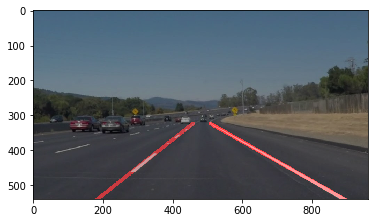

In [22]:
image_path = image_list[0]
image = mpimg.imread(image_path)
res_image = process_image(image)
print(os.path.basename(image_path))
plt.imshow(res_image)

solidWhiteRight.jpg


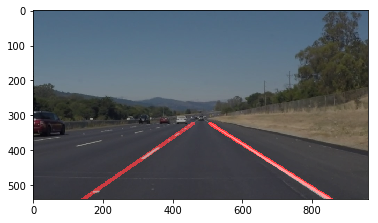

In [23]:
image_path = image_list[1]
image = mpimg.imread(image_path)
res_image = process_image(image)
print(os.path.basename(image_path))
plt.imshow(res_image)

solidYellowCurve.jpg


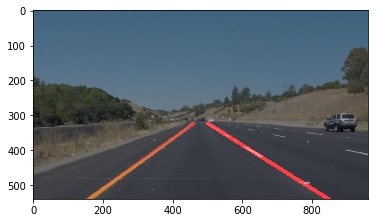

In [24]:
image_path = image_list[2]
image = mpimg.imread(image_path)
res_image = process_image(image)
print(os.path.basename(image_path))
plt.imshow(res_image)

solidYellowCurve2.jpg


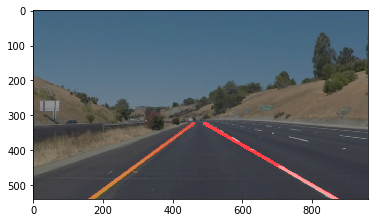

In [25]:
image_path = image_list[3]
image = mpimg.imread(image_path)
res_image = process_image(image)
print(os.path.basename(image_path))
plt.imshow(res_image)

solidYellowLeft.jpg


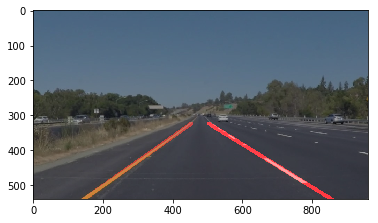

In [26]:
image_path = image_list[4]
image = mpimg.imread(image_path)
res_image = process_image(image)
print(os.path.basename(image_path))
plt.imshow(res_image)

whiteCarLaneSwitch.jpg


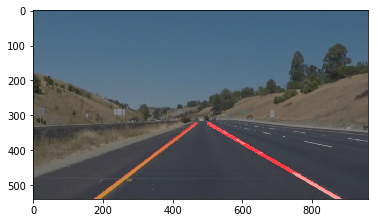

In [27]:
image_path = image_list[5]
image = mpimg.imread(image_path)
res_image = process_image(image)
print(os.path.basename(image_path))
plt.imshow(res_image)

## Test on Videos

Now we can test our solution on three provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

`challenge.mp4`


In [30]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [34]:
output = 'test_videos_output/solidWhiteRight.mp4'
clip3 = VideoFileClip('test_videos/solidWhiteRight.mp4')
clip = clip3.fl_image(process_image)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████▊| 221/222 [00:04<00:00, 51.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 4.57 s


In [38]:
HTML("""
<video width="480" height="270" controls>
  <source src="{0}">
</video>
""".format(output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [35]:
output = 'test_videos_output/solidYellowLeft.mp4'
clip3 = VideoFileClip('test_videos/solidYellowLeft.mp4')
clip = clip3.fl_image(process_image)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████▉| 681/682 [00:13<00:00, 50.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 13.9 s


In [37]:
HTML("""
<video width="480" height="270" controls>
  <source src="{0}">
</video>
""".format(output))

## Optional Challenge

Let's try our lane finding pipeline on the video below. It doesn't work as smooth as on previous ones, but still gives some result.

In [39]:
output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
clip = clip3.fl_image(process_image)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████| 251/251 [00:08<00:00, 27.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 9.49 s


In [40]:
HTML("""
<video width="480" height="270" controls>
  <source src="{0}">
</video>
""".format(output))